# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys

In [3]:
from Cluster import * 

Getting data:
getting JHU data...
expanding JHU data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
expansion done.
number of countries listed 274
done with JHU data (covid_ts dictionary keys: confirmed, deaths, recovered).  Got  274 countries (countries_jhu).
getting owid data...
expanding OWID data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
done with OWID data (covid_owid_ts dictionary see .keys()) . Got 212 countries (countries_owid)
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------
Constructing common synchronized deaths, case and testing data...
database JHU correct active True
done.
doing piecwise linear fits to testing data ...
done.
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default
----------

In [4]:
from model_fits import *  # including ModelFit class definition.

loading data.py...
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [5]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in countries_common if population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in countries_common if population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


186 countries with population data
common countries without population data []
68 cluster countries


In [6]:
[x for x in covid_ts]

['confirmed',
 'deaths',
 'recovered',
 'new_deaths',
 'new_deaths_smoothed',
 'deaths_smoothed',
 'new_deaths_corrected',
 'new_deaths_corrected_smoothed',
 'deaths_corrected_smoothed',
 'new_confirmed',
 'new_confirmed_smoothed',
 'confirmed_smoothed',
 'new_confirmed_corrected',
 'new_confirmed_corrected_smoothed',
 'confirmed_corrected_smoothed',
 'new_recovered',
 'new_recovered_smoothed',
 'recovered_smoothed',
 'new_recovered_corrected',
 'new_recovered_corrected_smoothed',
 'recovered_corrected_smoothed']

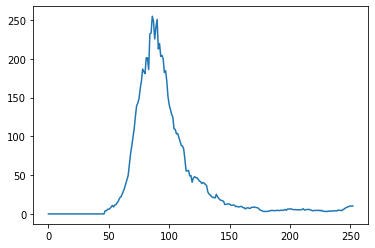

In [7]:
plt.plot(covid_ts['new_deaths_corrected_smoothed'][('Germany','')])

# Curve Fitting Example

We want to fit the following curve:

In [8]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

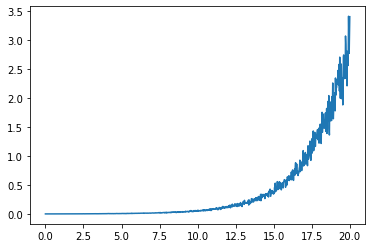

In [9]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [10]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [11]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [12]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

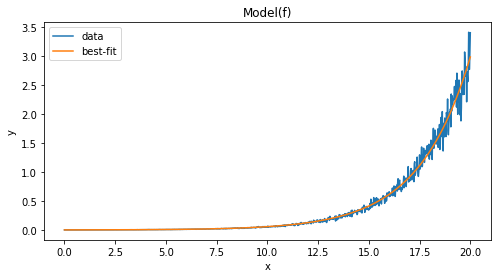

In [13]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [14]:
result

# Use `Modelfit.solvefit()` with `lmfit`

In [318]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [319]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2",data_src='owid')

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk :


In [320]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   #"mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [321]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [325]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  0.9727287292480469
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 134
    # data points      = 506
    # variables        = 4
    chi-square         = 7.1284e-05
    reduced chi-square = 1.4200e-07
    Akaike info crit   = -7974.34150
    Bayesian info crit = -7957.43535
[[Variables]]
    beta_1:  0.37362376 +/- 0.01279562 (3.42%) (init = 0.4)
    c_0:     0.26994117 +/- 0.02464849 (9.13%) (init = 0.1)
    c_1:     0.00889035 +/- 7.1140e-04 (8.00%) (init = 0.07)
    logI_0: -6.65213937 +/- 0.16760654 (2.52%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0)    = -0.968
    C(beta_1, logI_0) = -0.964
    C(c_0, logI_0)    =  0.922
    C(c_0, c_1)       = -0.447
    C(beta_1, c_1)    =  0.231
    C(c_1, logI_0)    = -0.214


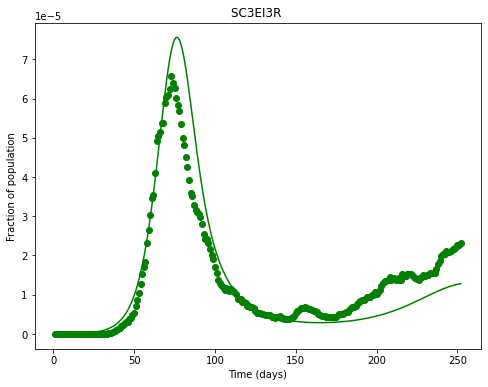

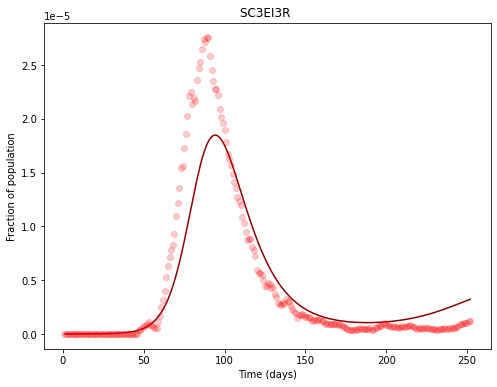

In [326]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

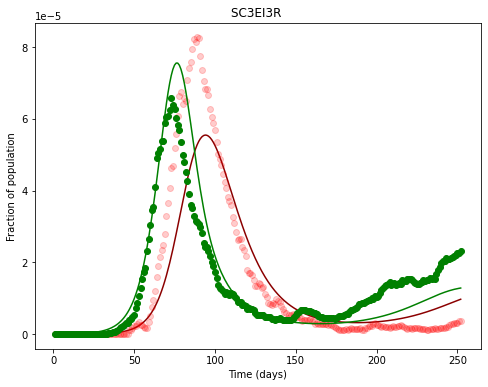

In [327]:
MyModel.solveplot(['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],mag={'deaths':30.})

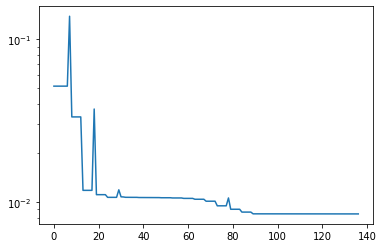

In [328]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

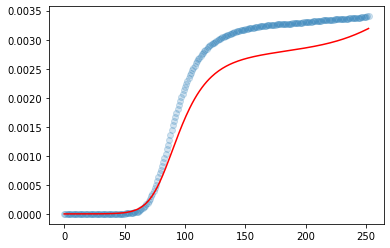

In [329]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [330]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'c_0', 'c_1', 'logI_0']

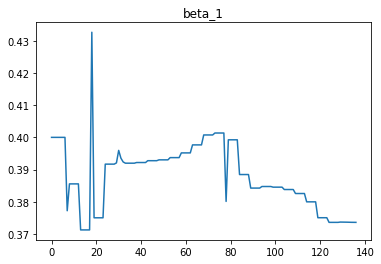

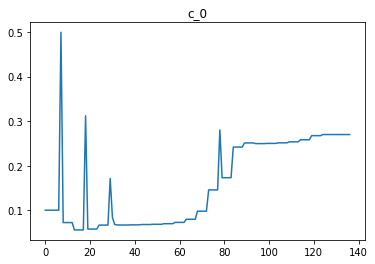

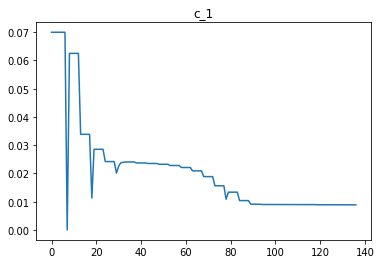

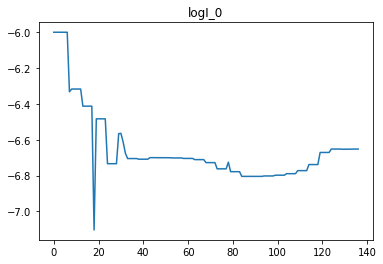

In [331]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

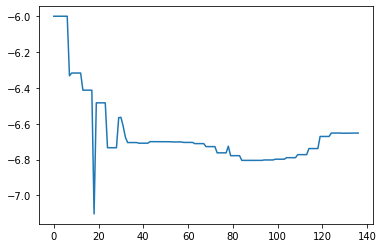

In [332]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [333]:
# outfit.params
MyModel.params

{'beta_1': 0.37362375990171137,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.26994116693991405,
 'c_1': 0.008890348577130154,
 'c_2': 5.0,
 'N': 1}

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* initially chose nelder, because of consistent gradual convergence.
* then switched back to leastsq as it gave fast reliable results after other problems had been resolved

## USA

In [417]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test3",data_src='owid')

For this run_id, a fresh file:  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test3.pk


In [418]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [419]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [420]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.730076789855957
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 506
    # variables        = 6
    chi-square         = 0.00122037
    reduced chi-square = 2.4407e-06
    Akaike info crit   = -6533.17815
    Bayesian info crit = -6507.81893
[[Variables]]
    beta_1:  0.38770814 +/- 0.10602356 (27.35%) (init = 0.4)
    mu:      0.07014348 +/- 0.00166139 (2.37%) (init = 0.05)
    c_0:     0.24731654 +/- 0.02082360 (8.42%) (init = 0.1)
    c_1:     0.09990786 +/- 0.05620945 (56.26%) (init = 0.07)
    c_2:     4.12086340 +/- 3.55381405 (86.24%) (init = 5)
    logI_0: -7.04683846 +/- 1.14101251 (16.19%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_0)        = -1.000
    C(beta_1, logI_0) = -0.997
    C(beta_1, c_2)    =  0.990
    C(c_1, c_2)       =  0.987
    C(c_2, logI_0)    = -0.979
    C(beta_1, c_1)    =  0.964
    C(c_1, logI_0)    = -0.949
    C(mu, c_1)        =  0.126
   

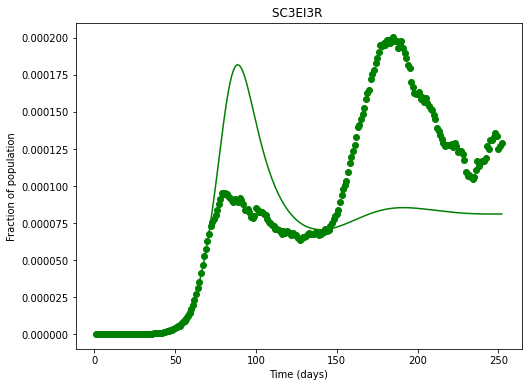

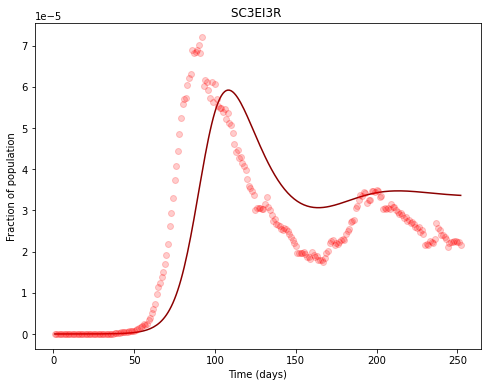

In [421]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

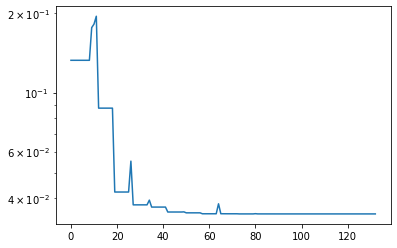

In [422]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

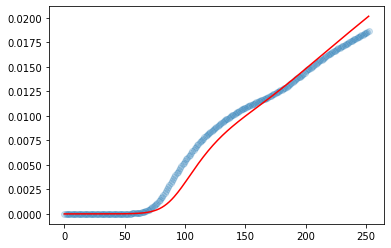

In [423]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [424]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

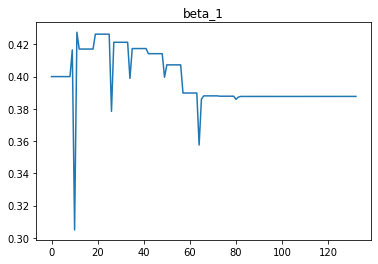

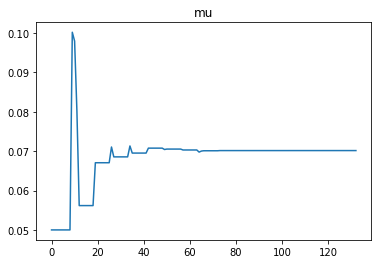

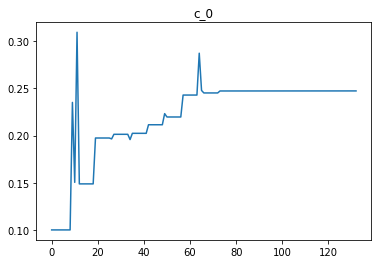

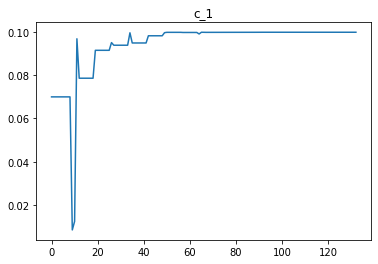

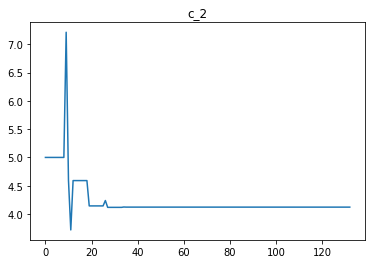

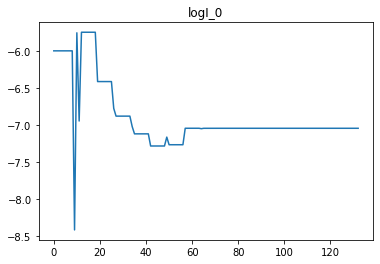

In [425]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

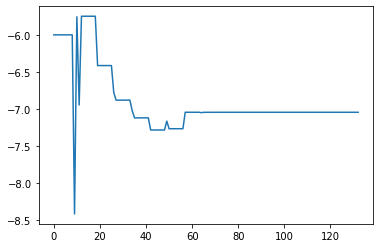

In [426]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany with method Nelder

In [427]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [431]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test5")

For this run_id, a fresh file:  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test5.pk


In [432]:
params_init_min_max = {"beta_1": (0.2, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [433]:
MyModel.params

{'beta_1': 0.2,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.05,
 'c_2': 2.0,
 'N': 1}

In [434]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 454
    # data points      = 506
    # variables        = 6
    chi-square         = 1.4825e-05
    reduced chi-square = 2.9649e-08
    Akaike info crit   = -8764.95101
    Bayesian info crit = -8739.59179
[[Variables]]
    beta_1:  0.33047857 +/- 0.00293038 (0.89%) (init = 0.2)
    mu:      0.09987067 +/- 0.00169838 (1.70%) (init = 0.1)
    c_0:     0.03382444 +/- 0.02330089 (68.89%) (init = 0.1)
    c_1:     0.01076458 +/- 1.7907e-04 (1.66%) (init = 0.05)
    c_2:     3.89465905 +/- 0.11979816 (3.08%) (init = 2)
    logI_0: -6.42929532 +/- 0.03669402 (0.57%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.861
    C(c_0, c_2)       =  0.837
    C(mu, c_0)        = -0.393
    C(c_0, logI_0)    =  0.339
    C(c_0, c_1)       =  0.327
    C(c_1, c_2)       =  0.291
    C(c_1, logI_0)    =  0.280
    C(beta_1, c_1)    = -0.274
    C(beta_1, c_2)    =  0.233
    C(

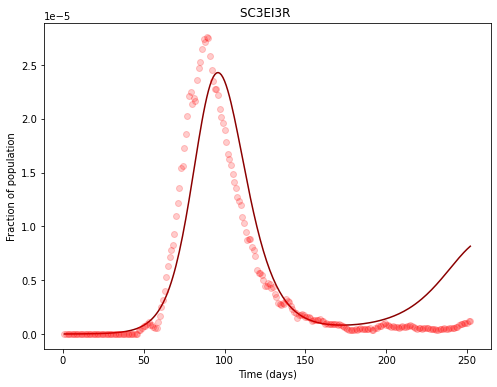

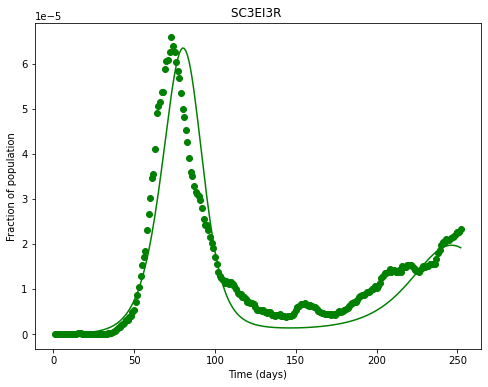

In [435]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [436]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [437]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [438]:
sliderparams = MyModel.allsliderparams(params_init_min_max)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='beta_1', layout=Layout(widt…

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### Test on USA

In [366]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2")

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test2.pk :


In [367]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.05, 0.0, 0.5),
                   "c_2": (2., 0.,20.), 
                    "logI_0": (-6.,-10.,0.0)}

In [368]:
MyModel.params

{'beta_1': 0.3877081436620393,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.07014347607783408,
 'c_0': 0.24731653503845485,
 'c_1': 0.09990785954516682,
 'c_2': 4.1208634021654085,
 'N': 1}

In [369]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2323
    # data points      = 506
    # variables        = 6
    chi-square         = 0.00139891
    reduced chi-square = 2.7978e-06
    Akaike info crit   = -6464.09166
    Bayesian info crit = -6438.73244
[[Variables]]
    beta_1:  0.43330470 +/- 0.00313735 (0.72%) (init = 0.2)
    mu:      0.09527131 +/- 0.00305340 (3.20%) (init = 0.1)
    c_0:     0.49439611 +/- 0.00334492 (0.68%) (init = 0.1)
    c_1:     6.4740e-04 +/- 4.8303e-04 (74.61%) (init = 0.05)
    c_2:     15.4289835 +/- 0.38916543 (2.52%) (init = 2)
    logI_0: -6.17783577 +/- 0.02545942 (0.41%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) =  2.242
    C(c_2, logI_0)    =  1.965
    C(c_0, logI_0)    = -1.423
    C(c_1, c_2)       =  1.351
    C(beta_1, c_1)    =  1.309
    C(beta_1, c_0)    = -0.973
    C(c_0, c_1)       = -0.907
    C(mu, logI_0)     =  0.849
    C(beta_1, mu)     = -0.619
    C

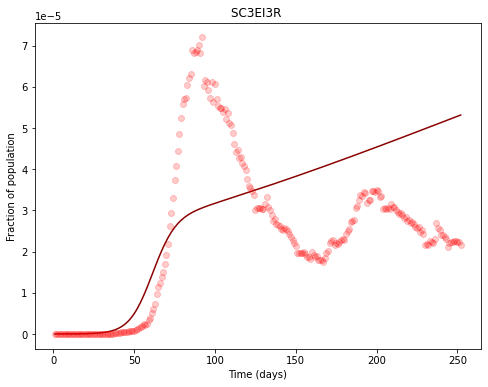

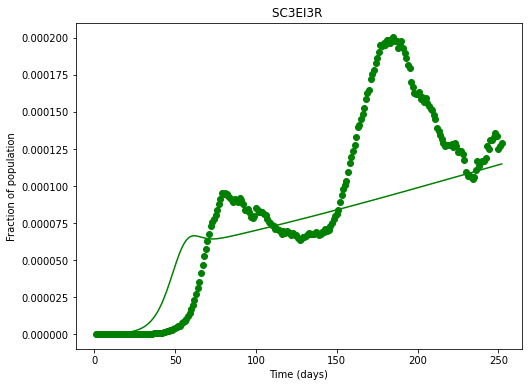

In [370]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.38, 0., 1., 0.001),
                       "alpha": (0.2,0.,1.,0.001),
                       "mu": (.125,0.,.2,0.001),
                       "c_0": (0.246, 0., 1.0,0.001),
                       "c_1": (0.044, 0.0, 0.5,0.001),
                       "c_2": (6.21, 2.,20.,0.01),
                       "logI_0": (-6.88,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries[0]

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan") # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

## Try for U model class

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test")

In [ ]:
{'beta_1': 0.37526113317338305,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.11549404287611789,
 'c_0': 0.2583441976053431,
 'c_1': 0.03763741590817468,
 'c_2': 3.620445327728954,
 'N': 1}

In [ ]:
params_init_min_max = {"beta_1": (0.37526113317338305, 0., 2.),
                       "alpha": (0.2, 0., 1.),
                       "mu": (0.11549404287611789,0.,.2),
                       "c_0": (0.2583441976053431, 0., 1.0),
                       "c_1": (0.03763741590817468, 0.0, 0.5),
                       "c_2": (3.620445327728954, 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
#                       "k_w": (1.0/90.0,0.0,1.0),
#                       "kappa": (0.5,0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [ ]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max)

In [ ]:
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq')

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solvefit(['deaths'])

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.2, 0., 1., 0.001),
                       "alpha": (0.1,0.,1.,0.001),
                       "mu": (.1,0.,.2,0.001),
                       "c_0": (0.1, 0., 1.0,0.001),
                       "c_1": (0.07, 0.0, 0.5,0.001),
                       "c_2": (5., 2.,20.,0.01),
                       "k_u": (1.0/5.0,0,1,0.001),
                       "k_1": (1.0/90.0,0.0,1.0,0.001),
                       "k_w": (1.0/90.0,0.0,1.0,0.001),
                       "kappa": (0.5,0.0,1.0,0.001),
                       "logI_0": (-6.,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
MyModel = ModelFit('SC3UEI3R',country=short_countries[0],run_id="_scan")

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [ ]:
MyModel.fit(params_init_min_max,diag=False)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0.1, 0.5),
                       "mu": (.1,0.05,.2),
                       "c_0": (0.1, 0.05, 0.5),
                       "c_1": (0.07, 0.02, 0.2),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan",data_src='jhu') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths'],fit_data='deaths_corrected_smoothed')
        MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()

# Pygom + minimize with sensitivities

## Previous pygom fitting example from `Caution_paper_Fitting`

In [ ]:
test_country = 'Germany'
fitdata = covid_ts['new_deaths_corrected_smoothed'][(test_country,'')]
t = list(range(len(fitdata)))

In [ ]:
plt.plot(fitdata);

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [ ]:
np.shape(t)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.40,0.1,0.3,0.0167,1000.] # cautionparams
# boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(6000.,12000.)]
boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(600.,1200.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=fitdata[1:],
                      # state_weight=[1.,10.],state_name=['R','D'],
                        state_weight=[1.],state_name=['D'],
                        target_param=['beta_1','mu','c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                # method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

# Fitting base params

In [371]:
[x for x in dir(MyModel) if 'param' in x]

['allsliderparams',
 'baseparams',
 'cbparams',
 'dbparams',
 'dumpparams',
 'fbparams',
 'getparams',
 'loadparams',
 'paramfile',
 'params',
 'prparams',
 'sbparams',
 'set_base_param',
 'set_param',
 'transfer_fit_to_params_init']

In [372]:
MyModel.prparams()


params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.4333047049491836,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.4943961144198846,
 'c_1': 0.0006473986375464258,
 'c_2': 15.428983504178593,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'mu': 0.09527131421050804,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.1,
 'FracMild': 0.7,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5,
 'logI_0': -6.522878745280337}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0}
cbparams:
{'CautionExposure': 0.1,
 'CautionFactor': 0.1,
 'CautionRetention': 60.0,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 60.0,
 'EconomicStriction': 30.0,
 'EconomyRelaxation': 60.0}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.99999336e-01, 0.00000000e+00, 6.63994118e-07, 0.00000000e+00,
       0.00000000e+00

In [373]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

## parameter setup for 3 rounds of fitting with standard values (use copy if want to edit)

In [374]:
params_init_min_max_1 = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [375]:
params_init_min_max_1U = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [376]:
params_init_min_max_2 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001)
}

In [377]:
params_init_min_max_2U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01)
}

In [378]:
params_init_min_max_3 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001)
}

In [379]:
params_init_min_max_3U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01),
    'EconomicStriction': (30,15,90,0.01),
    'EconomicRelaxation': (60,15,90,0.01),
    'EconomicCostOfCaution': (0.5,0.1,0.9,0.001)
}

## Example Germany

In [387]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test3")

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test3.pk :


In [388]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.125551223754883
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 506
    # variables        = 6
    chi-square         = 1.8042e-05
    reduced chi-square = 3.6084e-08
    Akaike info crit   = -8665.57296
    Bayesian info crit = -8640.21374
[[Variables]]
    Exposure:          0.41725284 +/- 0.00165033 (0.40%) (init = 0.4)
    logI_0:           -7.21182273 +/- 0.00359956 (0.05%) (init = -6.522879)
    CautionFactor:     0.22445657 +/- 0.00288136 (1.28%) (init = 0.1)
    CautionRetention:  84.5433986 +/- 0.04184283 (0.05%) (init = 60)
    CautionExposure:   0.11172951 +/- 3.5098e-05 (0.03%) (init = 0.1)
    FracConfirmedDet:  0.99953110 +/- 0.00804893 (0.81%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Exposure, logI_0)                   = -0.978
    C(Exposure, CautionFactor)            = -0.737
    C(logI_0, CautionFactor)              =  0.672
    C(CautionRetention, FracConfirme

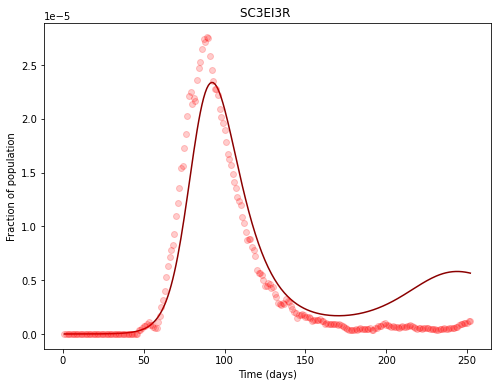

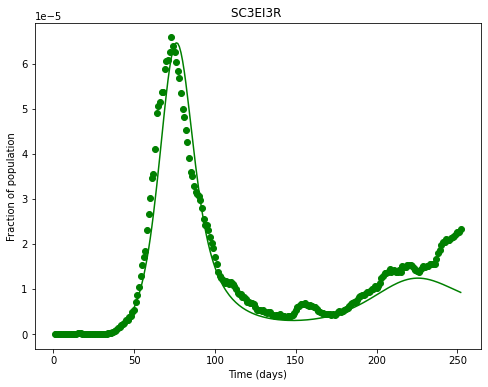

In [389]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

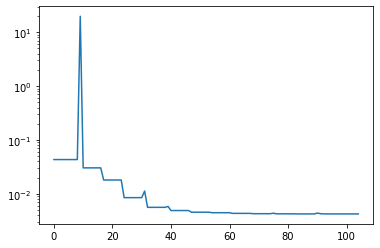

In [390]:
plt.semilogy(MyModel.residall);

elapsed time =  4.30914306640625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 263
    # data points      = 506
    # variables        = 13
    chi-square         = 2.3287e-05
    reduced chi-square = 4.7235e-08
    Akaike info crit   = -8522.44656
    Bayesian info crit = -8467.50158
##  Warning: uncertainties could not be estimated:
    FracCritical:      at initial value
    CautionRetention:  at boundary
    FracDeathsDet:     at initial value
    FracDeathsDet:     at boundary
[[Variables]]
    FracMild:          0.62122839 (init = 0.7)
    FracCritical:      0.10000000 (init = 0.1)
    CFR:               0.04374142 (init = 0.05)
    DurHosp:           4.00456425 (init = 4)
    DurMildInf:        9.98874972 (init = 10)
    Exposure:          0.41685872 (init = 0.4172528)
    logI_0:           -6.54674965 (init = -6.522879)
    TimeICUDeath:      6.47004593 (init = 5)
    CautionFactor:     0.29946811 (init = 0.2244566)
    CautionRetention:  89.99950

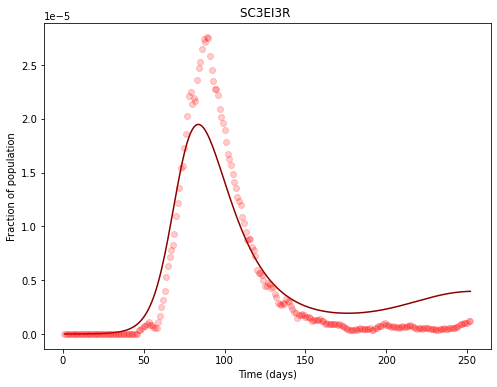

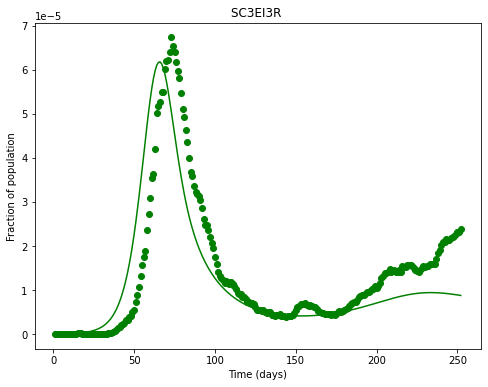

In [391]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

### slider plot for base params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### slider plot for ode params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.487, 0., 1., 0.001),
                       "alpha": (0.2,0.,1.,0.001),
                       "mu": (0.057,0.,.2,0.001),
                       "c_0": (0.1, 0., 1.0,0.001),
                       "c_1": (0.011, 0.0, 0.5,0.001),
                       "c_2": (4.15, 2.,20.,0.01),
                       "logI_0": (-6.85,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
MyModel.prparams()